# Build a CNN classifier for P300 speller

<div style="text-align:justify; width: 97%">
Main reference: *CNN With Large Data Achieves True Zero-Training in Online P300 Brain-Computer Interface* by J. Lee et al. (2020)
</div>

In [23]:
# import necessary packages
## Python standard libraries
import math
import random
import os

## Packages for computation and modelling
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
# from torcheeg.models import EEGNet
import mne
import pickle

## Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Self-defined packages
from swlda import SWLDA
from eegnet_utils import *

# Magic command to reload packages whenever we run any later cells
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Step 1. Data Preprocessing

In [4]:
BOARD = [["A",    "B",  "C",   "D",    "E",    "F",     "G",    "H"    ],
         ["I",    "J",  "K",   "L",    "M",    "N",     "O",    "P"    ],
         ["Q",    "R",  "S",   "T",    "U",    "V",     "W",    "X"    ],
         ["Y",    "Z",  "Sp",  "1",    "2",    "3",     "4",    "5"    ],
         ["6",    "7",  "8",   "9",    "0",    "Prd",   "Ret",  "Bs"   ],
         ["?",    ",",  ";",   "\\",   "/",    "+",     "-",    "Alt"  ],
         ["Ctrl", "=",  "Del", "Home", "UpAw", "End",   "PgUp", "Shft" ],
         ["Save", "'",  "F2",  "LfAw", "DnAw", "RtAw",  "PgDn", "Pause"],
         ["Caps", "F5", "Tab", "EC",   "Esc",  "email", "!",    "Sleep"]]
BOARD  = np.array(BOARD)
N_ROWS = BOARD.shape[0]  # number of rows
N_COLS = BOARD.shape[1]  # number of columns
M = N_ROWS * N_COLS      # the number of chars on the board

In [12]:
paradigm        = 'RC' # display paradigm ('RC', 'CB', or 'RD')
NUM_TIMESTAMPS  = 195  # number of timestamps in each window to record signals
NUM_CHANNELS    = 32   # number of eletrode channels
EPOCH_SIZE      = 195  # size of epoch, we don't aggregrate this time
NUM_TRAIN_WORDS = 5    # number of training words for one participant
NUM_TEST_WORDS  = 5    # number of testing words for one participant
obj_indices     = ['01', '02', '03', '04', '05', '06', '07',
                   '09', '14', '15', '16', '17', '19']

train_X_list, train_Y_list, test_X_list, test_Y_list = [], [], [], []
cwd = os.getcwd()
for obj in obj_indices:
    directory = os.path.abspath('../..') + '/BCI_data/EDFData-StudyA'
    obj_directory = directory + f'/A{obj}/SE001'

    train_features,train_response = load_data(dir=obj_directory,
                                              obj=obj,
                                              num_timestamps=NUM_TIMESTAMPS,
                                              epoch_size=EPOCH_SIZE,
                                              num_channels=NUM_CHANNELS,
                                              type=paradigm,
                                              mode='train',
                                              num_words=NUM_TRAIN_WORDS)
    train_X_list.append(train_features)
    train_Y_list.append(train_response.reshape((-1, 1)))

    test_features,test_response   = load_data(dir=obj_directory,
                                              obj=obj,
                                              num_timestamps=NUM_TIMESTAMPS,
                                              epoch_size=EPOCH_SIZE,
                                              num_channels=NUM_CHANNELS,
                                              type=paradigm,
                                              mode='test',
                                              num_words=NUM_TEST_WORDS)
    test_X_list.append(test_features)
    test_Y_list.append(test_response.reshape((-1, 1)))

In [13]:
train_X = torch.from_numpy(np.vstack(train_X_list))
train_Y = torch.from_numpy(np.vstack(train_Y_list))
test_X  = torch.from_numpy(np.vstack(test_X_list))
test_Y  = torch.from_numpy(np.vstack(test_Y_list))

# Resize the features and responses to fit the EEGNet model
train_X = torch.from_numpy(np.expand_dims(train_X, axis=1)) # [55692, 1, 32, 206]
test_X  = torch.from_numpy(np.expand_dims(test_X,  axis=1)) # [55692, 1, 32, 206]

train_Y = np.squeeze(train_Y) # [55692]
test_Y  = np.squeeze(test_Y) # [55692]

In [15]:
print(train_X.shape, train_Y.shape)
print(test_X.shape,  test_Y.shape)

torch.Size([55692, 1, 32, 206]) torch.Size([55692])
torch.Size([55692, 1, 32, 206]) torch.Size([55692])


In [21]:
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 1

trainset, testset = TensorDataset(train_X, train_Y), TensorDataset(test_X, test_Y)
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader  = DataLoader(dataset=testset,  batch_size=BATCH_SIZE, shuffle=False)

## Training the EEGNet classifier

Epoch 1/1
1741/1741 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]

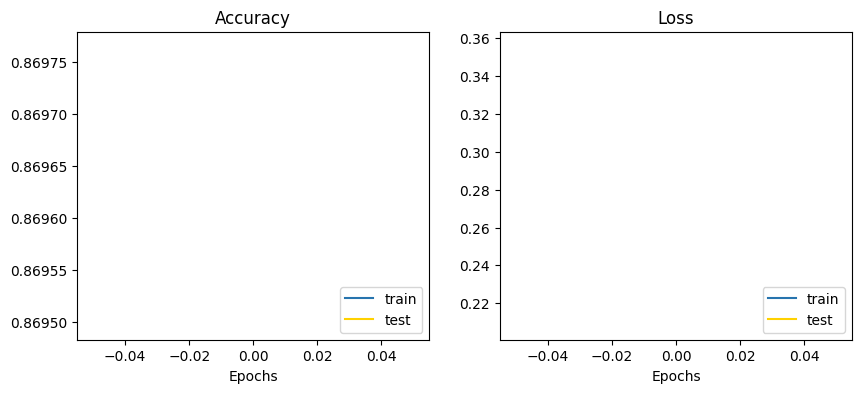

In [24]:
eegnet = EEGNet().to(device)
model = Model(eegnet, lr=LR)
history = model.fit(trainloader=trainloader, validloader=testloader,
                    epochs=EPOCHS, monitor=["acc", "val_acc"])
plot_acc_and_loss(history=history)

In [25]:
history

{'loss': array([0.20812429]),
 'acc': array([0.86949652]),
 'val_loss': array([0.35603786]),
 'val_acc': array([0.86976586])}